#### Nama : Angello Khara Sitanggang
#### NPM  : 220711833
#### Kelompok SB : Transformer
#### Arsitektur : VGG-16


In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"train_data"
img_size = 224
batch = 10
validation_split = 0.1

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch
)

total_count = len(dataset)
val_count = int(validation_split * total_count)
train_count = total_count - val_count 
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
    validation_split=validation_split,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
    validation_split=validation_split,
    subset="validation"
)

remaining_ds = dataset.skip(train_count)

class_names = train_ds.class_names

print(f"Total Images: {total_count}")
print(f"Train Images: {train_count}")
print(f"Validation Images: {val_count}")
print("Class names:", class_names)


Found 318 files belonging to 3 classes.
Found 318 files belonging to 3 classes.
Using 287 files for training.
Found 318 files belonging to 3 classes.
Using 31 files for validation.
Total Images: 32
Train Images: 29
Validation Images: 3
Class names: ['Busuk', 'Matang', 'Mentah']


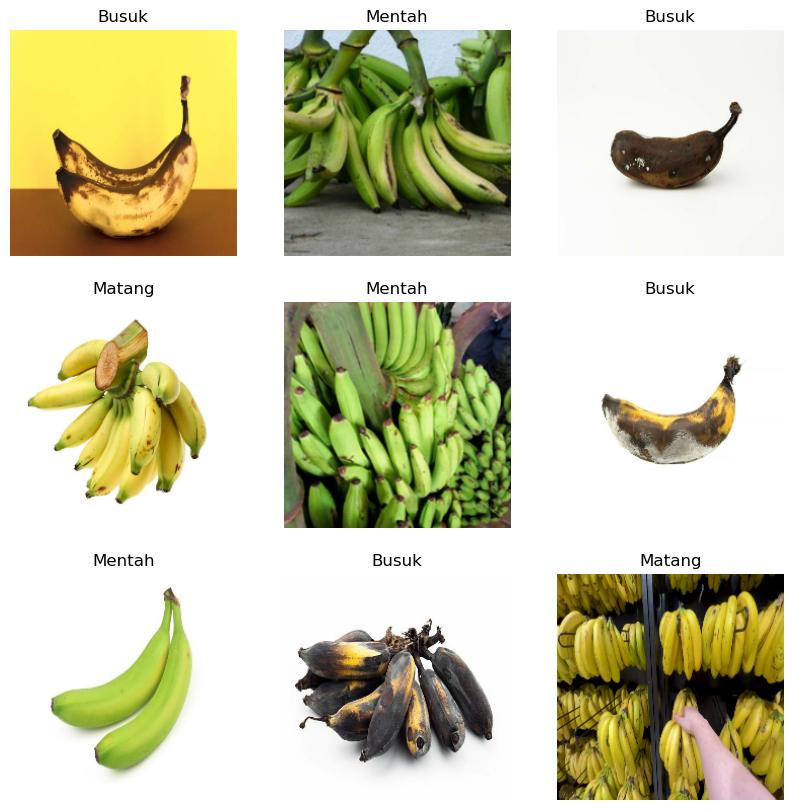

In [2]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [3]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)
    

(10, 224, 224, 3)


Train Images: 29
Validation Images: 3


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


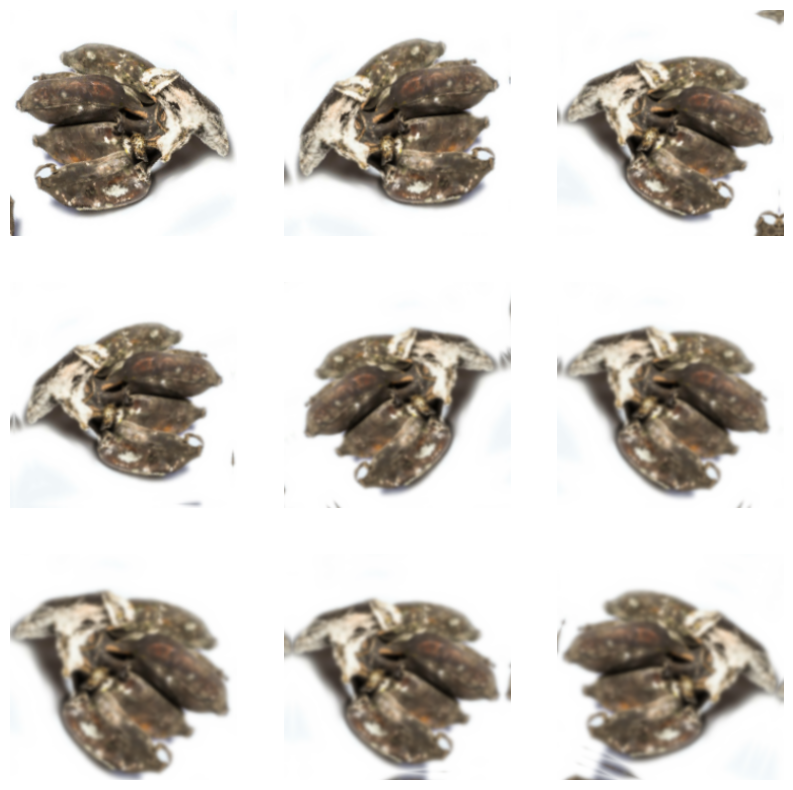

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

print(f"Train Images: {train_count}")
print(f"Validation Images: {val_count}")


i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(69):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [5]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.backend import clear_session

def vgg16(input_shape, n_classes):
    input = Input(input_shape)

    # Block 1
    x = Conv2D(64, 3, padding='same', activation='relu')(input)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)

    # Block 2
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)

    # Block 3
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)

    # Block 4
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)

    # Block 5
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model


input_shape = (224, 224, 3)  
n_classes = 3 

clear_session()

model = vgg16(input_shape, n_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,29

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 134,272,835 (512.21 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, 
                               mode='max')


history= model.fit(train_ds, 
                   epochs=10, 
                   validation_data=val_ds, 
                   callbacks=[early_stopping])

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.3591 - loss: 31.6513 - val_accuracy: 0.3226 - val_loss: 1.1158
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.3623 - loss: 1.1311 - val_accuracy: 0.2581 - val_loss: 1.1376
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.3257 - loss: 1.1093 - val_accuracy: 0.3226 - val_loss: 1.1130
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.3302 - loss: 1.1001 - val_accuracy: 0.3226 - val_loss: 1.1064
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.3688 - loss: 1.0965 - val_accuracy: 0.3226 - val_loss: 1.1059
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.3184 - loss: 1.1027 - val_accuracy: 0.3226 - val_loss: 1.1051


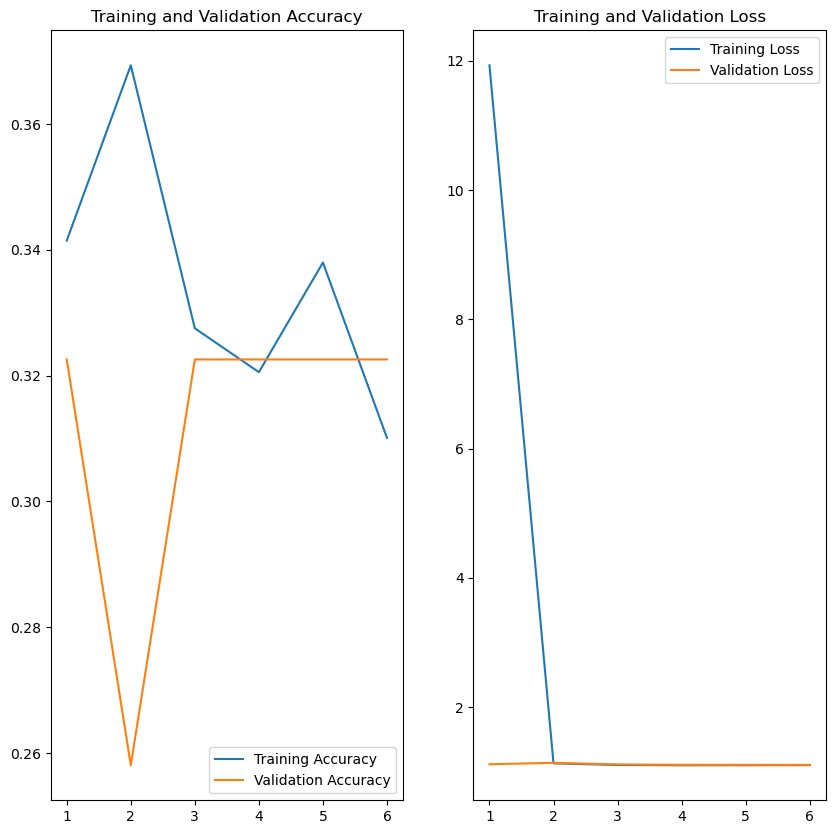

In [10]:

ephocs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save('VGG16.h5', save_format='h5')



In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image


model = load_model(r'VGG16.h5')  
class_names = ['Matang', 'Mentah','Busuk']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:

        input_image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  # Add batch dimension


        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"
result = classify_images(r'Prediksi\Busuk\pisangbusuk (124).jpg', save_path='busuk.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Prediksi: Mentah
Confidence: 33.72%
Prediksi: Mentah dengan confidence 33.72%. Gambar asli disimpan di busuk.jpg.


Found 36 files belonging to 3 classes.


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step


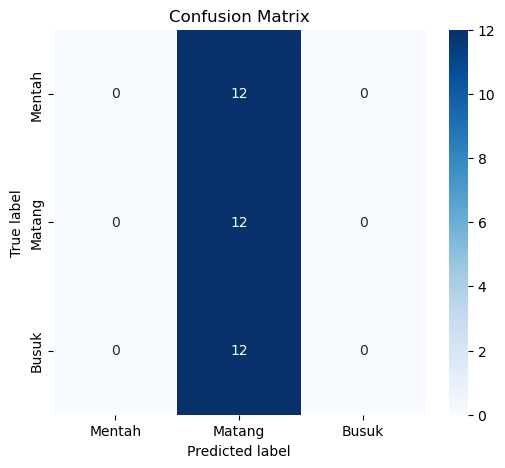

Confusion Matrix:
 [[ 0 12  0]
 [ 0 12  0]
 [ 0 12  0]]
Accuracy: 0.3333333333333333
Precision: [       nan 0.33333333        nan]
Recall: [0. 1. 0.]
F1 Score: [nan 0.5 nan]


In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',
    labels='inferred',
    label_mode='categorical',  
    batch_size=32,
    image_size=(224, 224)
)


y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1) 


true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy()) 
true_labels = tf.convert_to_tensor(true_labels)


conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Mentah", "Matang","Busuk"], yticklabels=["Mentah", "Matang","Busuk"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
###Terdapat code yang hilang disini! lihat modul untuk menemukanya
print("Confusion Matrix:\n", conf_mat.numpy())
print("Accuracy:", accuracy.numpy())
print("Precision:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())